<a href="https://colab.research.google.com/github/dev-marcos/LSTM-Time-Series-Analysis-of-Cryptocurrency-Prices/blob/main/Previsao_preco_BITCOIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importado as Bibliotecas

In [1]:
import pandas as pd
import numpy as np

# Carregando o Dataset
Fonte dos dados: https://finance.yahoo.com/quote/BTC-USD/history

In [2]:
df_btc_usd = pd.read_csv('BTC-USD.csv')
df_btc_usd['Date'] = pd.to_datetime(df_btc_usd['Date'])
df_btc_usd = df_btc_usd.sort_values(by=['Date'], ascending=True) 

In [3]:
print('Número total de dias presentes no conjunto de dados: ',df_btc_usd.shape[0])

Número total de dias presentes no conjunto de dados:  2999


In [4]:
df_btc_usd.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
df_btc_usd.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2994,2022-11-28,16440.222656,16482.933594,16054.530273,16217.322266,16217.322266,27743025156
2995,2022-11-29,16217.639648,16522.257813,16139.396484,16444.982422,16444.982422,23581685468
2996,2022-11-30,16445.476563,17190.937500,16445.476563,17168.566406,17168.566406,29523576583
2997,2022-12-01,17168.001953,17197.498047,16888.388672,16967.132813,16967.132813,22895392882
2998,2022-12-02,16974.273438,17048.888672,16896.314453,17048.888672,17048.888672,21018572800


In [6]:
df_btc_usd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 0 to 2998
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2999 non-null   datetime64[ns]
 1   Open       2999 non-null   float64       
 2   High       2999 non-null   float64       
 3   Low        2999 non-null   float64       
 4   Close      2999 non-null   float64       
 5   Adj Close  2999 non-null   float64       
 6   Volume     2999 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 187.4 KB


In [7]:
sd=df_btc_usd.iloc[0][0]
ed=df_btc_usd.iloc[-1][0]


print('Data Inicial',sd)
print('Data Final',ed)

Data Inicial 2014-09-17 00:00:00
Data Final 2022-12-02 00:00:00


In [8]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20, 6)
mpl.rcParams['font.size'] = 22

(array([735234., 735599., 735964., 736330., 736695., 737060., 737425.,
        737791., 738156., 738521.]),
 <a list of 10 Text major ticklabel objects>)

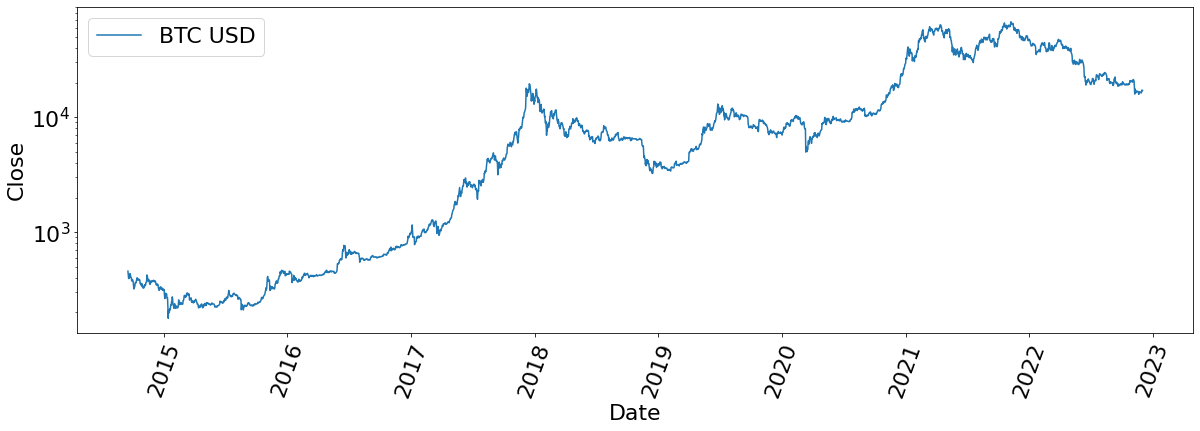

In [75]:
sns.lineplot(x='Date',y='Close', data=df_btc_usd, label='BTC USD') 
plt.yscale('log')
plt.xticks(rotation=70)

In [71]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()

redimensionar a base de dados, com valores entre 0 e 1, sendo esta uma das exigências que o software LSTM possui para poder ser utilizado. Além disto, é necessário aplicar um reshape(-1,1) pois inicialmente o vetor é unidimensional, ao executar esta função, a entrada passa a ter duas dimensões, que é a entrada esperada pelo modelo LSTM. 

In [12]:
scaler.fit(df_btc_usd['Close'].values.reshape(-1,1))
scaled_data = scaler.transform(df_btc_usd['Close'].values.reshape(-1,1))

In [13]:
scaled_data

array([[-0.76067854],
       [-0.76270208],
       [-0.76452568],
       ...,
       [ 0.26734471],
       [ 0.25495314],
       [ 0.2599825 ]])

#Dividindo em treino e teste

In [14]:
train_size = int(len(df_btc_usd) * 0.9)
test_size = len(df_btc_usd) - train_size

In [15]:
train , test = scaled_data[0: train_size] , scaled_data[ train_size :len(df_btc_usd)]

In [16]:
print('Treino: ',train.shape)
print('Teste: ',test.shape)

Treino:  (2699, 1)
Teste:  (300, 1)


(array([735234., 735599., 735964., 736330., 736695., 737060., 737425.,
        737791., 738156., 738521.]),
 <a list of 10 Text major ticklabel objects>)

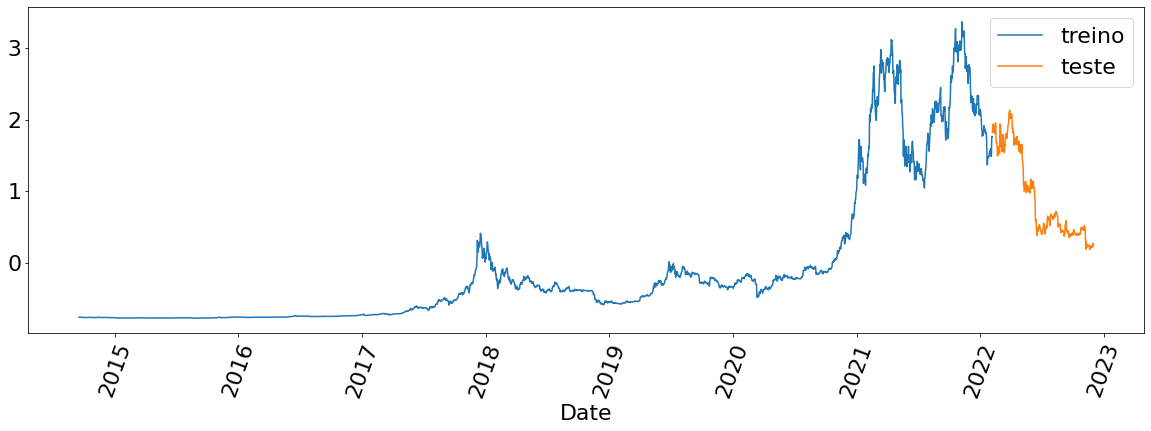

In [73]:
sns.lineplot(x='Date',y=train[:,0],data=df_btc_usd[0:train_size],label='treino') 
sns.lineplot(x='Date',y=test[:,0], data=df_btc_usd[train_size:len(df_btc_usd)],label='teste')

plt.xticks(rotation=70) 

#Preparando os dados para o modelo

In [18]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 15
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2683, 15)
y_train:  (2683,)
X_test:  (284, 15)
y_test (284,)


In [20]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2683, 15, 1)
X_test:  (284, 15, 1)


#Modelo LSTM

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [52]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))


model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [53]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
84/84 [==============================] - 2s 10ms/step - loss: 0.9053 - val_loss: 0.8575
Epoch 2/100
84/84 [==============================] - 1s 9ms/step - loss: 0.3801 - val_loss: 0.1040
Epoch 3/100
84/84 [==============================] - 1s 8ms/step - loss: 0.0139 - val_loss: 0.0093
Epoch 4/100
84/84 [==============================] - 1s 8ms/step - loss: 0.0049 - val_loss: 0.0107
Epoch 5/100
84/84 [==============================] - 1s 8ms/step - loss: 0.0046 - val_loss: 0.0099
Epoch 6/100
84/84 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 0.0102
Epoch 7/100
84/84 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0104
Epoch 8/100
84/84 [==============================] - 1s 8ms/step - loss: 0.0043 - val_loss: 0.0089
Epoch 9/100
84/84 [==============================] - 1s 8ms/step - loss: 0.0041 - val_loss: 0.0106
Epoch 10/100
84/84 [==============================] - 1s 9ms/step - loss: 0.0041 - val_loss: 0.0109
Epoch 1

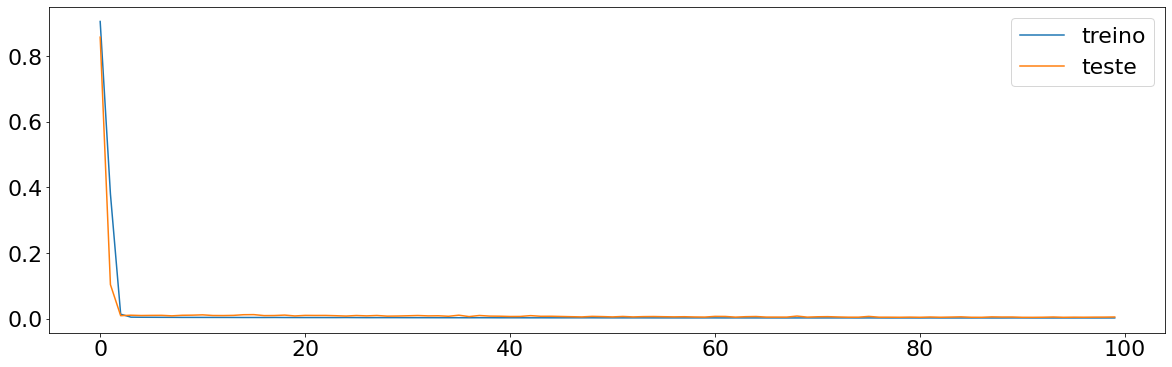

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['treino','teste'])
plt.show()

In [55]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

9/9 [==============================] - 0s 3ms/step


((2683, 1), (284, 1))

# Transforma de volta à forma original

In [56]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(test.reshape(-1,1)) 

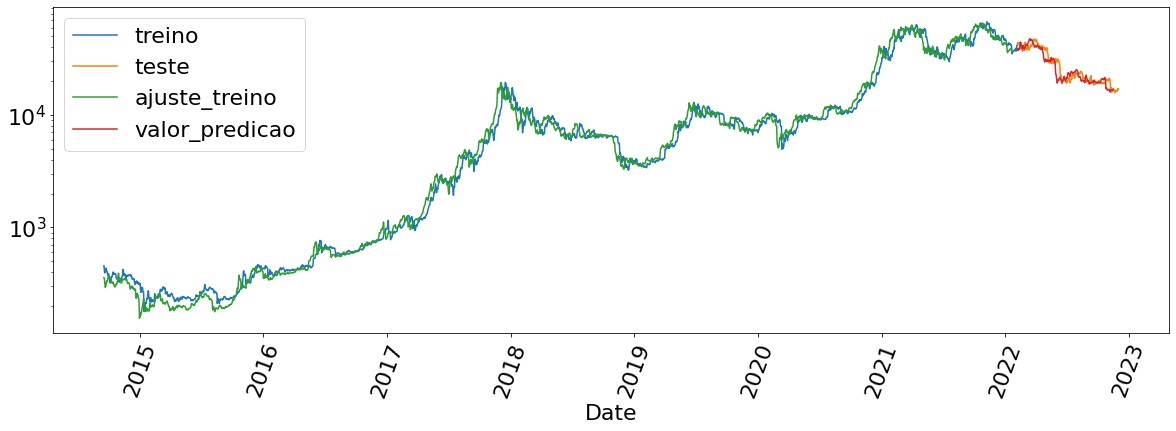

In [57]:

sns.lineplot(x='Date',y=original_ytrain[:,0],data=df_btc_usd[0:train_size],label='treino') 
sns.lineplot(x='Date',y=original_ytest[:,0], data=df_btc_usd[train_size:len(df_btc_usd)],label='teste')
sns.lineplot(x='Date',y=train_predict[:,0],data=df_btc_usd[0:train_predict.shape[0]],label='ajuste_treino')
sns.lineplot(x='Date',y=test_predict[:,0],data=df_btc_usd[train_size:(train_size+test_predict.shape[0])],label='valor_predicao')
plt.xticks(rotation=70) 
plt.yscale('log')

#Prevendo os próximos 30 dias

In [58]:
from datetime import date, timedelta
from numpy import array

In [63]:

x_input=test[len(test)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()



lst_output=[]
date_predicted = []
n_steps=time_step
pred_days = 30

for i in range (pred_days):

    date_predicted.append(ed+timedelta(i+1))

    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])

        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())

               
print("Saída dos próximos dias previstos: ", len(lst_output))

Saída dos próximos dias previstos:  30


In [64]:
next_predicted_days_value = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

(array([738481., 738490., 738497., 738504., 738511., 738521.]),
 <a list of 6 Text major ticklabel objects>)

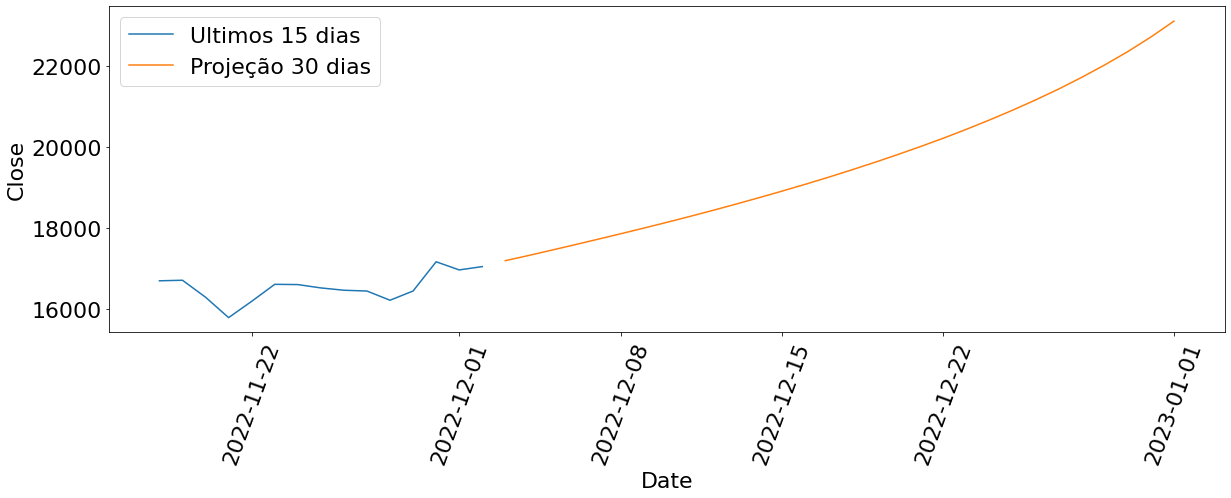

In [65]:
#sns.lineplot(x='Date',y=original_ytrain[:,0],data=df_btc_usd[0:train_size],label='treino') 
#sns.lineplot(x='Date',y=original_ytest[:,0], data=df_btc_usd[train_size:len(df_btc_usd)],label='teste')
#sns.lineplot(x='Date',y=train_predict[:,0],data=df_btc_usd[0:train_predict.shape[0]],label='ajuste_treino')
#sns.lineplot(x='Date',y=test_predict[:,0],data=df_btc_usd[train_size:(train_size+test_predict.shape[0])],label='valor_predicao')

sns.lineplot(x='Date',y='Close', data=df_btc_usd[(df_btc_usd.shape[0]-time_step):], label='Ultimos 15 dias')
sns.lineplot(x=date_predicted,y=next_predicted_days_value,label='Projeção 30 dias')

plt.xticks(rotation=70) 


In [ ]:
sns.lineplot(x='Date',y='Close', data=df_btc_usd[(df_btc_usd.shape[0]-time_step):], label='Ultimos 15 dias')
sns.lineplot(x=date_predicted,y=next_predicted_days_value,label='Projeção 30 dias')


In [68]:
date_predicted[-1],next_predicted_days_value[-1]

(Timestamp('2023-01-01 00:00:00'), 23120.518866802042)